In [143]:
from bs4 import BeautifulSoup 
import requests 
import re
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Get the data
Url's of interesting countries, in our scenarion it will be Poland, Malysia and Belgium.

In [144]:
bg = 'https://www.worldometers.info/coronavirus/country/belgium/'
mal = 'https://www.worldometers.info/coronavirus/country/malaysia/'
pl = 'https://www.worldometers.info/coronavirus/country/poland/'

Get the content of page

In [145]:
page = requests.get(pl) 
soup = BeautifulSoup(page.content) 

Use regexp to get this kind of data: <br>
&emsp; name: 'Recovery Rate',<br>
&emsp; color: '#8ACA2B',<br>
&emsp; lineWidth: 5,<br>
&emsp; data: [ numbers ]

In [146]:
names = re.findall(r'series: \[\{\s*name: \'([a-zA-Z\s ]*)\'[a-zA-Z\#0-9\s\n\,\.\'\: ]*data: \[([0-9\,\s\.null ]*)\]', page.text)

Split names and data

In [147]:
datas = [n[1] for n in names]
names = [n[0] for n in names]

Make data more userfirendly - to floats and then to np.array

In [148]:
datas = [d.split(',') for d in datas]

In [149]:
datas = [[ np.nan if d == 'null' else float(d) for d in data] for data in datas]

In [164]:
datas = np.nan_to_num(datas,0)

In [150]:
datas = np.array(datas)
datas.shape

(10, 110)

Names of each array

In [155]:
for i, n in enumerate(names):
    print(i,n)

0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 Death Rate


Get dates

In [141]:
dates = re.findall(r'categories: \[([\"A-Za-z\s0-9\, ]*)\]\n', page.text)[0]
dates = dates.replace('"','').split(',')
len(dates)

110

# Real data

In [157]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [178]:
#restrictions
r0 = dates.index('Mar 16')
r1 = dates.index('Mar 24')
r2 = dates.index('Mar 31')
#freedoms
f0 = dates.index('Apr 20')
f1 = dates.index('May 04')
f2 = dates.index('May 18')
f3 = dates.index('May 30')

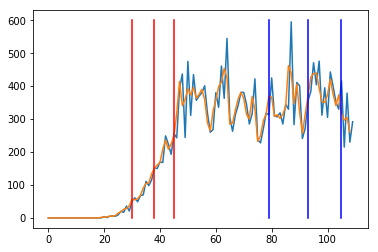

In [183]:
plt.plot(datas[4])
plt.plot(moving_average(datas[4],2))
plt.plot([r0,r0],[0,600], c='r')
plt.plot([r1,r1],[0,600], c='r')
plt.plot([r2,r2],[0,600], c='r')
plt.plot([f1,f1],[0,600], c='b')
plt.plot([f2,f2],[0,600], c='b')
plt.plot([f3,f3],[0,600], c='b')

# Calculation od model

Iitialize parameters

In [121]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

Function to count derivatives <br>
credit: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [122]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

Run model

In [123]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

Plotting results

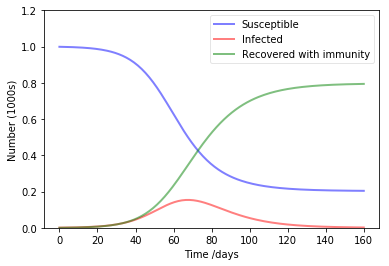

In [131]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure()
plt.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')
plt.ylim(0,1.2)
legend = plt.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Poland
Koronawirus COVID-19. Czwarty etap znoszenia ograniczeń [30.05.2020] <br>
Zniesienie obowiązku zasłaniania ust i nosa w przestrzeni otwartej [30.05.2020] <br>
Koronawirus COVID-19. Trzeci etap znoszenia ograniczeń [18.05.2020] <br>
Koronawirus COVID-19. Drugi etap znoszenia ograniczeń [04.05.2020] <br>
Koronawirus COVID-19. Pierwszy etap znoszenia ograniczeń [20.04.2020] <br>
Obowiązek zasłaniania ust i nosa [16.04.2020] <br>
Ograniczenia na Wielkanoc [09.04.2020] <br>
Wprowadzenie kolejnych ograniczeń i zakazów w Polsce [31.03.2020] <br>
Nowe restrykcje i ograniczenia wprowadzone w Polsce [24.03.2020] <br>
Stan zagrożenia epidemicznego w Polsce – jakie ograniczenia wprowadzono? [16.03.2020] <br> 
https://www.medonet.pl/koronawirus-pytania-i-odpowiedzi/sars-cov-2,koronawirus---obostrzenia-w-polsce--etapy-znoszenia-ograniczen--aktualne-dane-,artykul,98382723.html